In [1]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import numpy as np

from afc_prep import full_waveform
from afc_prep import full_waveform_noshift

In [49]:
# device params
samp_rate = 2.4e9  # unit: Hz
volt_range = 5  # unit: V

# EOM params
Vpi = 3.9  # unit: V

# waveform params
A = Vpi / (volt_range * np.pi)  # overall amplitude of pulse (after normalization)
N = 10
delta = 1e6  # unit: Hz
tau = 2e-3  # unit: s
beta = 10 / tau
delta_f = 0.7e6  # unit: Hz
f_0 = 100e6  # unit: Hz
f_light = 195e12  # light frequency (in Hz)

resolution = 1 / samp_rate  # unit: s
num_points = tau / resolution
num_points = (num_points // 16) * 16  # round to multiple of 16

t, theta, amp = (
    full_waveform(N, delta, num_points, resolution, beta, f_light, delta_f))

239


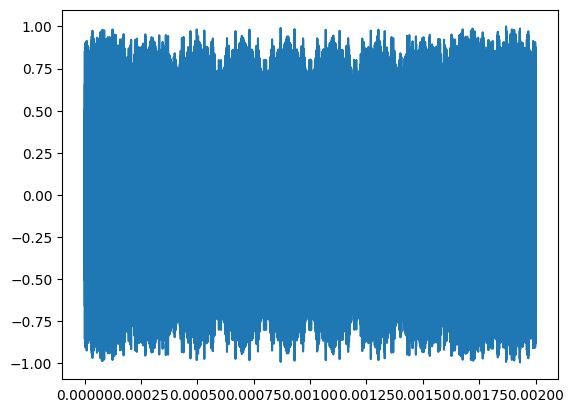

In [50]:
# for testing
DETUNING = 1.0
Vpi = Vpi * DETUNING

# shift amplitude
shift = 100e-9  # unit: seconds
shift_idx = int(shift / resolution)
print(shift_idx)
amp_shifted = np.roll(amp, shift_idx)

normalized_amp = amp_shifted / amp_shifted.max()
w0 = 2 * np.pi * f_0
wav = normalized_amp * np.sin(w0*t + theta)

plt.plot(t, wav)
plt.show()

In [51]:
# determine FFT
num_points = int(num_points)
T = resolution
yf = fft(wav)
xf = fftfreq(num_points, T)[:num_points//2] * 1e-6

# scale and average
yf_to_plot = 2.0 / num_points * np.abs(yf[0:num_points//2])

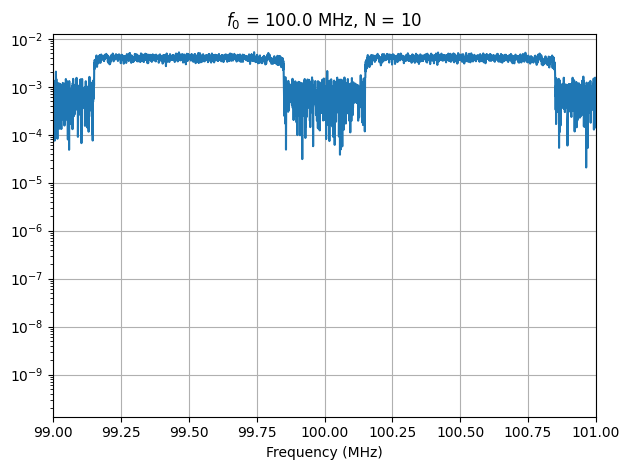

In [52]:
center = w0 / (2*np.pi*1e6)  # center of plot (MHz)
# width = (delta / 1e6) * N  # MHz
width = 2*delta / 1e6

fig, ax = plt.subplots()

ax.plot(xf, yf_to_plot)
# ax.plot(xf, 2.0 / num_points * np.abs(yf_sin[0:num_points // 2]),
#         alpha=0.5, label='Sine Approximation')
ax.set_yscale('log')

ax.set_title(rf"$f_0$ = {f_0//1e6} MHz, N = {N}")
ax.set_xlabel('Frequency (MHz)')
ax.set_xlim(center-width/2, center+width/2)
# ax.set_ylim((0, 0.001))
ax.grid()

plt.tight_layout()
plt.show()

In [53]:
shifts = np.linspace(-500e-9, 500e-9, 100)
ffts = np.zeros((100, num_points//2))

for i, shift in enumerate(shifts):
    # shift amplitude
    shift_idx = int(shift / resolution)
    amp_shifted = np.roll(amp, shift_idx)
    
    normalized_amp = amp_shifted / amp_shifted.max()
    w0 = 2 * np.pi * f_0
    wav = normalized_amp * np.sin(w0*t + theta)

    # determine FFT
    num_points = int(num_points)
    T = resolution
    yf = fft(wav)
    xf = fftfreq(num_points, T)[:num_points//2] * 1e-6
    
    # scale and average
    yf_to_plot = 2.0 / num_points * np.abs(yf[0:num_points//2])
    
    ffts[i,:] = yf_to_plot

In [54]:
center = w0 / (2*np.pi*1e6)  # center of plot (MHz)
width = 2*delta / 1e6
idx_to_keep = np.where(np.logical_and(xf >= center-width/2, xf <= center+width/2))[0]
fft_to_keep = ffts[:, idx_to_keep]

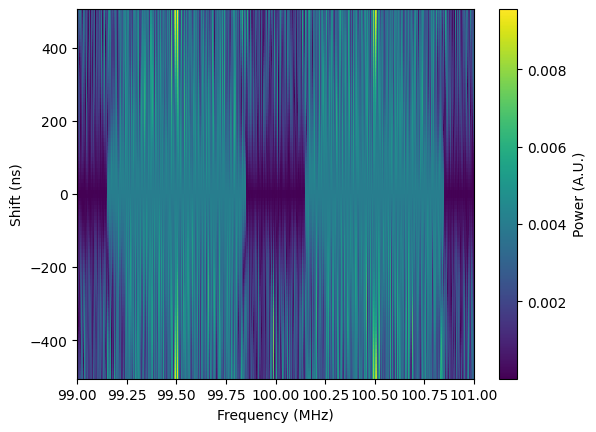

In [57]:
X, Y = np.meshgrid(xf[idx_to_keep], shifts * 1e9)

plt.pcolormesh(X, Y, fft_to_keep)

plt.xlabel("Frequency (MHz)")
plt.ylabel("Shift (ns)")
plt.colorbar(label="Power (A.U.)")